In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchsummary import summary
import torch_directml

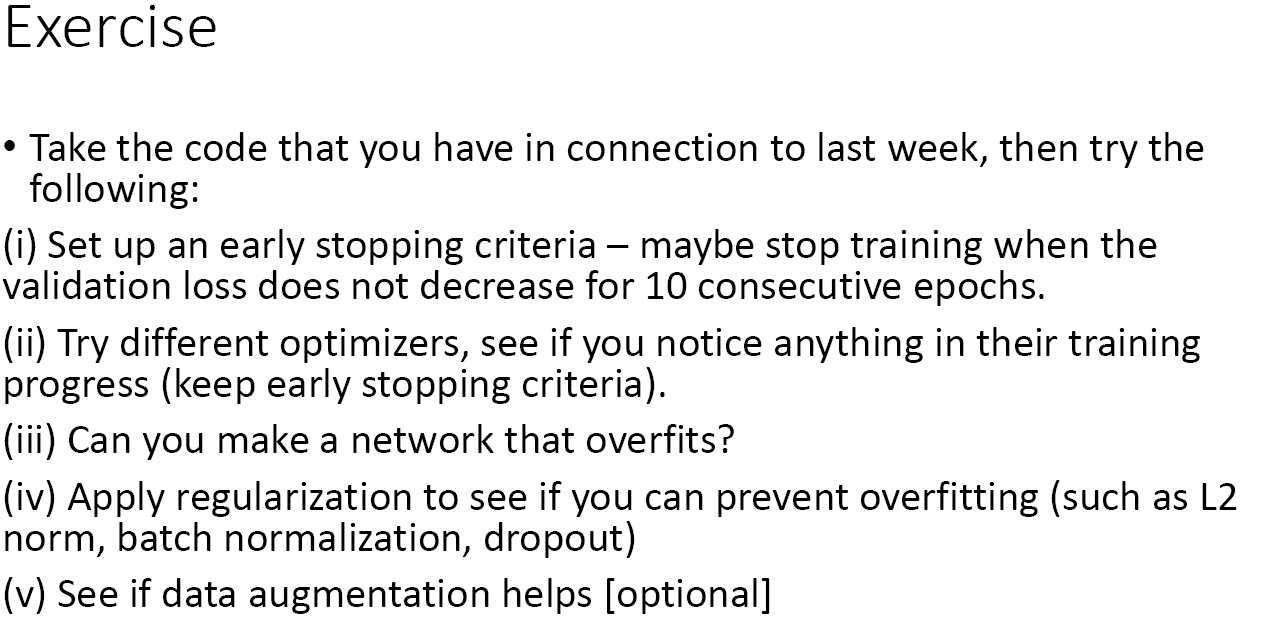

# i)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Number of samples in the training data: 60000
Number of samples in the test data: 10000
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


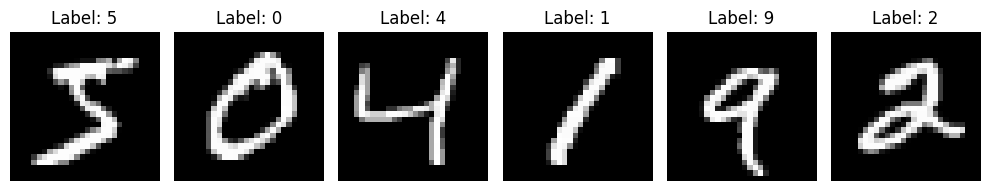

Number of DirectML devices: 1
NeuralNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=256, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


In [8]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

classes = training_data.classes
print(classes)

num_training_samples = len(training_data)
print(f"Number of samples in the training data: {num_training_samples}")

num_test_samples = len(test_data)
print(f"Number of samples in the test data: {num_test_samples}")

batch_size = 64 # we will talk about it later

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, pin_memory=True)

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")

    fig, axes = plt.subplots(1, 6, figsize=(10, 10))
    axes = axes.flatten()

    for i in range(6):
        img = X[i].squeeze().numpy()
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(f"Label: {y[i]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    break
# Get cpu, gpu or mps device for training.
device = torch_directml.device(torch_directml.default_device()) 
# device = "cpu"

# Check the number of available DirectML devices
num_devices = torch_directml.device_count()
print(f"Number of DirectML devices: {num_devices}")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1,)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1,)

        # Pooling layer
        self.pool = nn.MaxPool2d(2,2)

        # Linear layer
        self.linear1 = nn.Linear(256,120)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(84, 10)
        
        # Activation layer
        self.relu = nn.ReLU(inplace=True)

        # Flatten
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        return x

model = NeuralNetwork().to(device)
print(model)
loss_fn = nn.CrossEntropyLoss()
# Try different optimizers
# optimizer = torch.optim.SGD(model.parameters(), lr=0.002) # Let's use stocastic gradient descent (We will talk about it in the coming weeks)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

# Initialization 
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss, correct = 0, 0  # Track the total loss for the epoch

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        total_loss += loss.item()  # Accumulate loss
    
        # Backpropagation
        model.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    avg_loss = total_loss / len(dataloader)  # Calculate average loss for the epoch
    avg_accuracy = correct / size

    train_losses.append(avg_loss)  # Store the average loss for the epoch
    train_accuracies.append(avg_accuracy) # Store the average accuracy for the epoch

    print(f"Train loss: {avg_loss:>7f}, Accuracy: {(100*avg_accuracy):>0.1f}%")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    test_losses.append(test_loss)  # Store the test loss for the epoch
    test_accuracies.append(correct)

    print(f"Test Error: \n Avg loss: {test_loss:>8f}, Accuracy: {(100*correct):>0.1f}% \n")
    return round(test_loss,2)

In [9]:
# Early stopping parameters
patience = 5
best_test_loss = float('inf')
epochs_without_improvement = 0
number_epochs = 1
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    current_test_loss = test(test_dataloader, model, loss_fn)
    
    # Early stopping logic
    if current_test_loss < best_test_loss:
        best_test_loss = current_test_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {number_epochs} epochs.")
        break
    print(f"Epochs without improvement: {epochs_without_improvement+1}")
    number_epochs += 1
print("Training completed.")


Epoch 1
-------------------------------
loss: 2.318508  [   64/60000]
loss: 0.315642  [ 6464/60000]
loss: 0.158561  [12864/60000]
loss: 0.237825  [19264/60000]
loss: 0.136720  [25664/60000]
loss: 0.063072  [32064/60000]
loss: 0.146466  [38464/60000]
loss: 0.113968  [44864/60000]
loss: 0.329114  [51264/60000]
loss: 0.094469  [57664/60000]
Train loss: 0.235683, Accuracy: 92.7%
Test Error: 
 Avg loss: 0.093723, Accuracy: 97.0% 

Epochs without improvement: 1
Epoch 2
-------------------------------
loss: 0.046146  [   64/60000]
loss: 0.109737  [ 6464/60000]
loss: 0.038085  [12864/60000]
loss: 0.134329  [19264/60000]
loss: 0.046747  [25664/60000]
loss: 0.049251  [32064/60000]
loss: 0.121296  [38464/60000]
loss: 0.036269  [44864/60000]
loss: 0.163513  [51264/60000]
loss: 0.063405  [57664/60000]
Train loss: 0.073941, Accuracy: 97.8%
Test Error: 
 Avg loss: 0.055160, Accuracy: 98.1% 

Epochs without improvement: 1
Epoch 3
-------------------------------
loss: 0.011651  [   64/60000]
loss: 0.08

SGD time = 13min, epochs = 36
Adam time = 13min, epochs = 10


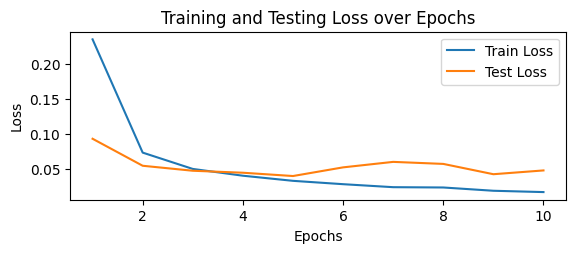

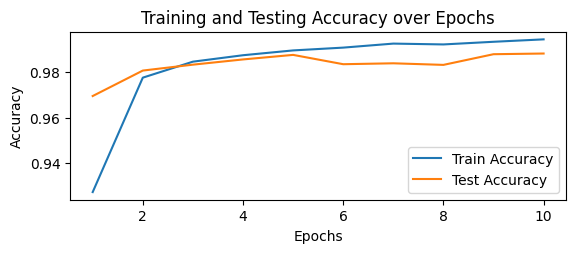

In [10]:
print("SGD time = 13min, epochs = 36")
print("Adam time = 13min, epochs = 10")

plt.subplot(2,1,1)
plt.plot(range(1, number_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, number_epochs+1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Testing Loss over Epochs")
plt.legend()
plt.show()

plt.subplot(2,1,2)
plt.plot(range(1, number_epochs+1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, number_epochs+1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Testing Accuracy over Epochs")
plt.legend()
plt.show()

# SDG optimizer
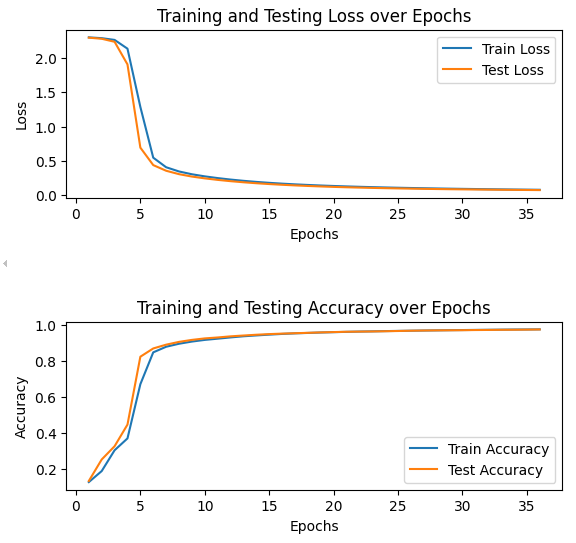
# Adam optimizer
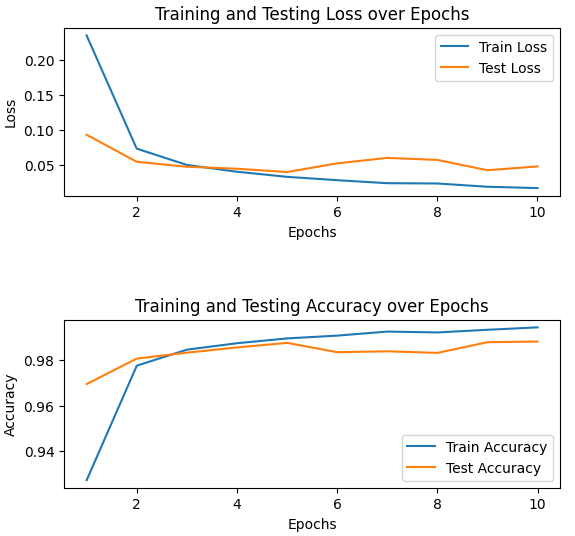